## WebScrapping

In [1]:
import requests
from bs4 import BeautifulSoup       
# URL of the sample blog page
url = 'https://ieknet.iek.org.tw/iekrpt/DefaultFree.aspx?currentPageIndex=1&domain=0&indu_idno=0&actiontype=rpt'  # Replace with the actual blog URL
# Send a GET request to the page
# also send the purpose of request in headers
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
    'Purpose': 'course practicing, email :t.hsu7@lse.ac.uk, phone: +44 7491 770206'
}   


In [15]:
# ! pip install playwright
# ! playwright install chromium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 16.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [playwright]2 [playwright]
(node:91930) [DEP0169] DeprecationWarning: `url.parse()` behavior is not standardized and prone to errors that have security implications. Use the WHATWG URL API instead. CVEs are not issued for `url.parse()` vulnerabilities.
(Use `node --trace-deprecation ...` to show where the warning was created)
159.6 MiB [                    ] 0% 0.0s159.6 MiB [                    ] 0% 66.8s159.6 MiB [                    ] 0% 313.3s159.6 MiB [                    ] 0% 429.0s159.6 MiB [                    ] 0% 233.4s159.6 MiB [                    ] 0% 226.4s159.6 MiB [                    ] 0% 208.7s159.6 MiB [                    ] 0% 195.2s159.6 MiB [                    ] 0% 183.0s159.6 MiB [                    ] 0% 214.6s159.6 MiB [                    ] 0% 150.4s159.6 MiB [                    ] 0% 105.3s159.6 MiB [                    ] 0

In [2]:
response = requests.get(url, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Parse the HTML content of the page
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find all article titles (assuming they are in <h2> tags with class 'post-title')
    titles = soup.find_all('h2', class_='g-font-weight-600')
    
    # Print the titles
    for title in titles:
        print(title.get_text(strip=True))




工研院盤點CES 2026　七大AI關鍵趨勢　AI落地成形　產業全面轉型
IEKView：服務業數位轉型與智慧機器人新契機
IEKView：全球藥品市場與台灣新藥出口競爭力
IEKView：擁抱量子革命
IEKView: Service Industry Digital Transformation: Emerging Opportunities with Smart Robotics
IEKView: Riding the AI Trend to Seize Business Opportunities in the Green Transition
新創引領轉型風潮　工研院論壇發表2026年十大創新趨勢
Zettabyte財務長龍牧生：算力資本化啟動全球AI新競局
工研院「眺望2026產業發展趨勢研討會」登場　以AI與量子為核心　四大策略打造臺灣量子產業生態系
2025 IEKTopics｜剖析量子科技新創聚落形成的三大類模式


In [ ]:
for page_num in range(1, 10):  
    url = f'https://ieknet.iek.org.tw/iekrpt/DefaultFree.aspx?currentPageIndex={page_num}&domain=0&indu_idno=0&actiontype=rpt'
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        titles = soup.find_all('h2', class_='g-font-weight-600')
        
        print(f'--- Page {page_num} ---')
        for title in titles:
            print(title.get_text(strip=True))



In [ ]:
import asyncio
from playwright.async_api import async_playwright
from bs4 import BeautifulSoup

BASE = "https://ieknet.iek.org.tw"
LIST_URL = f"{BASE}/iekrpt/DefaultFree.aspx?currentPageIndex=1&domain=0&indu_idno=0&actiontype=rpt"
USER_DATA_DIR = "iek_user_data"  

def extract_fulltext_from_html(html: str) -> str:
    soup = BeautifulSoup(html, "html.parser")
    content = soup.select_one("#contentIn")
    if not content:
        return ""
    paragraphs = [
        p.get_text(strip=True)
        for p in content.find_all("p")
        if p.get_text(strip=True)
    ]
    return "\n\n".join(paragraphs)

async def main():
    async with async_playwright() as p:
        browser = await p.chromium.connect_over_cdp("http://127.0.0.1:9222")
        context = browser.contexts[0]
        page = context.pages[0] if context.pages else await context.new_page()

        await page.goto(LIST_URL, wait_until="domcontentloaded")


        first_href = await page.locator("h2.g-font-weight-600 a").first.get_attribute("href")
        if not first_href:
            print("❌ 清單頁找不到第一篇")
            await context.close()
            return

        if first_href.startswith("./"):
            first_href = first_href[2:]
        if first_href.startswith("/"):
            article_url = BASE + first_href
        else:
            article_url = f"{BASE}/iekrpt/{first_href}"

        print("文章網址：", article_url)

        await page.goto(article_url, wait_until="domcontentloaded")

        login_btn = page.locator('a.btn.u-btn-outline-primary[href*="rpt_detail.aspx"]')
        if await login_btn.count() > 0:
            await login_btn.first.click()
            print("⚠️ 偵測到需要登入，請在瀏覽器完成登入")
            input("登入完成後，回來這裡按 Enter 繼續抓全文：")

        await page.goto(article_url, wait_until="networkidle")

        html = await page.content()
        fulltext = extract_fulltext_from_html(html)

        if not fulltext:
            print("❌ 抓不到 #contentIn")
            print("頁面 title：", await page.title())
            print("目前 URL：", page.url)
        else:
            print("\n=== 文章全文 ===\n")
            print(fulltext)

        await context.close()

await main()

In [3]:
from pymongo import MongoClient, UpdateOne


In [ ]:
MONGO_URI = input("Please enter your database URL: ")
DB_NAME = "iek_news"
COLL_NAME = "news_articles"

In [ ]:
import asyncio
from playwright.async_api import async_playwright
from bs4 import BeautifulSoup

from pymongo import MongoClient, UpdateOne
from datetime import datetime, timezone
from urllib.parse import urlparse, parse_qs

BASE = "https://ieknet.iek.org.tw"

# MONGO_URI = "mongodb+srv://<user>:<password>@iek-news.mls0jon.mongodb.net/?retryWrites=true&w=majority"
# DB_NAME = "iek"
# COLL_NAME = "articles"

def extract_fulltext_from_html(html: str) -> str:
    soup = BeautifulSoup(html, "html.parser")

    root = soup.select_one("#contentIn")
    if not root:
        root = soup.select_one("div.article__content")
    if not root:
        return ""

    parts = []
    for el in root.select("h1,h2,h3,p,li"):
        t = el.get_text(" ", strip=True)
        if not t:
            continue
        if t.replace("\xa0", "").strip() == "":
            continue
        parts.append(t)

    return "\n\n".join(parts)

def to_abs_iekrpt_url(href: str) -> str:
    href = (href or "").strip()
    if href.startswith("./"):
        href = href[2:]
    if href.startswith("/"):
        return BASE + href
    return f"{BASE}/iekrpt/{href}"

def get_rpt_idno(url: str):
    qs = parse_qs(urlparse(url).query)
    return qs.get("rpt_idno", [None])[0]

async def main():
    mongo_client = MongoClient(MONGO_URI)
    coll = mongo_client[DB_NAME][COLL_NAME]

    try:
        async with async_playwright() as p:
            browser = await p.chromium.connect_over_cdp("http://127.0.0.1:9222")
            context = browser.contexts[0]
            page = context.pages[0] if context.pages else await context.new_page()

            print("已連上 CDP。請確認這個 Chrome 視窗已登入 IEK。")

            for page_num in range(1, 11):
                list_url = f"{BASE}/iekrpt/DefaultFree.aspx?currentPageIndex={page_num}&domain=0&indu_idno=0&actiontype=rpt"
                await page.goto(list_url, wait_until="domcontentloaded")

                a_list = page.locator("h2.g-font-weight-600 a[href]")
                cnt = await a_list.count()
                print(f"\n--- Page {page_num} --- items={cnt}")

                hrefs = []
                for i in range(cnt):
                    href = await a_list.nth(i).get_attribute("href")
                    if href:
                        hrefs.append(href)

                # ✅ 這頁的 docs 先收集起來，最後一次寫入 DB
                docs = []

                for i, href in enumerate(hrefs, 1):
                    article_url = to_abs_iekrpt_url(href)
                    print(f"[{page_num}-{i}] goto:", article_url)

                    await page.goto(article_url, wait_until="domcontentloaded")

                    # 若看到「請登入後使用」，改走 rpt_detail
                    login_btn = page.locator('a.btn.u-btn-outline-primary[href*="rpt_detail.aspx"]')
                    if await login_btn.count() > 0:
                        detail_href = await login_btn.first.get_attribute("href")
                        if detail_href:
                            detail_url = to_abs_iekrpt_url(detail_href)
                            await page.goto(detail_url, wait_until="networkidle")
                    else:
                        await page.wait_for_load_state("networkidle")

                    html = await page.content()
                    fulltext = extract_fulltext_from_html(html)
                    title = await page.title()

                    print(f"    title: {title}")
                    print(f"    content_len: {len(fulltext)}")

                    rpt_idno = get_rpt_idno(article_url)
                    if not rpt_idno:
                        continue

                    docs.append({
                        "rpt_idno": str(rpt_idno),
                        "url": article_url,
                        "title": title,
                        "content": fulltext,
                        "content_len": len(fulltext),
                        "page_index": page_num,
                        "scraped_at": datetime.now(timezone.utc),
                    })

        
                if docs:
                    ops = [
                        UpdateOne({"rpt_idno": d["rpt_idno"]}, {"$set": d}, upsert=True)
                        for d in docs
                    ]
                    result = coll.bulk_write(ops, ordered=False)
                    print("DB bulk_write:", {
                        "upserted": result.upserted_count,
                        "modified": result.modified_count,
                        "matched": result.matched_count,
                    })
                else:
                    print("DB: no docs to write")

    finally:
        mongo_client.close()

await main()

已連上 CDP。請確認這個 Chrome 視窗已登入 IEK。

--- Page 1 --- items=10
[1-1] goto: https://ieknet.iek.org.tw/iekrpt/rpt_more.aspx?actiontype=rpt&indu_idno=0&domain=2&rpt_idno=422248746
    title: 工研院盤點CES 2026　七大AI關鍵趨勢　AI落地成形　產業全面轉型|IC產業|半導體|產業焦點|產科國際所【IEK產業情報網】
    content_len: 2998
[1-2] goto: https://ieknet.iek.org.tw/iekrpt/rpt_more.aspx?actiontype=rpt&indu_idno=0&domain=66&rpt_idno=927434121
    title: IEKView：服務業數位轉型與智慧機器人新契機|雲端運算、資安技術與應用|資通訊|產業焦點|產科國際所【IEK產業情報網】
    content_len: 1282
[1-3] goto: https://ieknet.iek.org.tw/iekrpt/rpt_more.aspx?actiontype=rpt&indu_idno=0&domain=73&rpt_idno=922314263
    title: IEKView：全球藥品市場與台灣新藥出口競爭力|醫療器材與材料|生技醫療|產業焦點|產科國際所【IEK產業情報網】
    content_len: 1163
[1-4] goto: https://ieknet.iek.org.tw/iekrpt/rpt_more.aspx?actiontype=rpt&indu_idno=0&domain=2&rpt_idno=981822297
    title: IEKView：擁抱量子革命|IC產業|半導體|產業焦點|產科國際所【IEK產業情報網】
    content_len: 1328
[1-5] goto: https://ieknet.iek.org.tw/iekrpt/rpt_more.aspx?actiontype=rpt&indu_idno=0&domain=82&rpt_idno=732156209
    

Future exception was never retrieved
future: <Future finished exception=TargetClosedError('Target page, context or browser has been closed')>
playwright._impl._errors.TargetClosedError: Target page, context or browser has been closed
Task exception was never retrieved
future: <Task finished name='Task-46' coro=<Waiter.reject_on_timeout.<locals>.reject() done, defined at /opt/anaconda3/lib/python3.13/site-packages/playwright/_impl/_waiter.py:85> exception=TargetClosedError(': Target page, context or browser has been closed')>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/playwright/_impl/_waiter.py", line 87, in reject
    self._reject(TimeoutError(message))
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/playwright/_impl/_waiter.py", line 111, in _reject
    self._wait_for_event_info_after(self._wait_id, exception)
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib

    title: 川普政策新動向-重建美國夢：能源主導、經濟安全、國家安全、與社會強韌|地緣政治下產業鏈變化與科技競爭|國際產經|產業焦點|產科國際所【IEK產業情報網】
    content_len: 1559
DB bulk_write: {'upserted': 10, 'modified': 0, 'matched': 0}

--- Page 9 --- items=10
[9-1] goto: https://ieknet.iek.org.tw/iekrpt/rpt_more.aspx?actiontype=rpt&indu_idno=0&domain=90&rpt_idno=1007471977
    title: IEK360系列｜台商布局新興市場 留意碳定價新規|淨零永續對策與商機|綠能與環境|產業焦點|產科國際所【IEK產業情報網】
    content_len: 6558
[9-2] goto: https://ieknet.iek.org.tw/iekrpt/rpt_more.aspx?actiontype=rpt&indu_idno=0&domain=20&rpt_idno=85697004
    title: 工研院「CES 2025重點趨勢研討會」重磅解析九大趨勢：AI滲透一切，未來已來|IC應用與市場|半導體|產業焦點|產科國際所【IEK產業情報網】
    content_len: 4408
[9-3] goto: https://ieknet.iek.org.tw/iekrpt/rpt_more.aspx?actiontype=rpt&indu_idno=0&domain=2&rpt_idno=1004118428
    title: 2025年美國晶片政策變化方向|IC產業|半導體|產業焦點|產科國際所【IEK產業情報網】
    content_len: 6425
[9-4] goto: https://ieknet.iek.org.tw/iekrpt/rpt_more.aspx?actiontype=rpt&indu_idno=0&domain=11&rpt_idno=3094348
    title: IEKView：改善缺工 解決傳產難題|3C與新興應用關鍵零組件|零組件及材料|產業焦點|產科國際所【IE

In [6]:
#retrieve data from mongo db
from pprint import pprint
MONGO_URI = input("Please enter your database URL: ")


client = MongoClient(MONGO_URI)
db = client["iek_news"]
collection = db["news_articles"]
for doc in collection.find().limit(5):
    pprint(doc) 

{'_id': ObjectId('697a1af31e6fee9fed0ffc5d'),
 'content': '美國消費電子展（CES）作為全球最具指標性的消費性電子展會，向來被視為年度科技產業的重要風向球。隨著AI技術全面重塑產業樣貌，工研院今（15）日舉辦「透視大展系列：CES '
            '2026重點趨勢研討會」，分享第一手展會觀察。工研院指出，今年 CES大會以「Innovators Show '
            'Up」為主題，凸顯AI時代創新的關鍵角色，也呼應當前產業的重要轉折——實體AI加速落地、對話式AI全面滲透，正成為推動產業前行的核心動能。\n'
            '\n'
            '工研院觀察，今年CES是一場由AI主導的科技轉型，並呈現多項關鍵趨勢，正深刻影響未來數年的生活樣貌與產業格局。一方面，AI算力仍是產業關注重點，NVIDIA、AMD與Intel不再只著眼晶片效能，而是強調從硬體、軟體到平台的整體整合；另一方面，實體AI（Physical '
            'AI）持續推進，AI應用逐漸從對話場景延伸至機器人、自動駕駛與各類終端裝置。同時，沉浸式體驗與智慧裝置持續升級，Google旗下Gemini '
            'AI 串聯電視、手機、穿戴與車用場景，反映「萬物皆有AI」的發展正逐步落實。\n'
            '\n'
            '趨勢一：智慧影像、對話式互動與AI家居生態系，打造沉浸式體驗\n'
            '\n'
            '在消費應用端，影像體驗朝向更沉浸、更智慧發展，RGB Mini-LED 與 Micro RGB '
            '顯示技術普及，AI扮演「視覺管家」的角色，透透過 Vision AI '
            '等技術即時優化畫面、依情境推薦內容。生成式AI（GenAI）也成為電視與家電的核心，對話式介面讓冰箱、烤箱能辨識食材時提供料理建議。今年 '
            'CES 也展現了「情境感知」的威力。智慧眼鏡能偵測使用者走進廚房，立即將食譜傳送到冰箱螢幕上；多元感知（Multi-modal '
            'sensing）讓裝置能辨識語音、手

In [7]:
import pandas as pd
doc_df = pd.DataFrame(list(collection.find()))
doc_df.head()

,_id,rpt_idno,content,content_len,page_index,scraped_at,title,url
0,697a1af31e6fee9fed0ffc5d,422248746,美國消費電子展（CES）作為全球最具指標性的消費性電子展會，向來被視為年度科技產業的重要風向...,2998,1,2026-01-28 14:17:26.616,工研院盤點CES 2026 七大AI關鍵趨勢 AI落地成形 產業全面轉型|IC產業|半導體|...,https://ieknet.iek.org.tw/iekrpt/rpt_more.aspx...
1,697a1af31e6fee9fed0ffc5e,927434121,隨著「顧客體驗」成為企業成長的核心驅動力，服務業對消費者滿意度的重視程度大幅提升。根據McK...,1282,1,2026-01-28 14:17:34.526,IEKView：服務業數位轉型與智慧機器人新契機|雲端運算、資安技術與應用|資通訊|產業焦點...,https://ieknet.iek.org.tw/iekrpt/rpt_more.aspx...
2,697a1af31e6fee9fed0ffc60,981822297,量子科技正加速從實驗室邁向產業應用，被視為繼AI之後最具顛覆性的科技革命，我認為台灣在這場關...,1328,1,2026-01-28 14:17:50.406,IEKView：擁抱量子革命|IC產業|半導體|產業焦點|產科國際所【IEK產業情報網】,https://ieknet.iek.org.tw/iekrpt/rpt_more.aspx...
3,697a1af31e6fee9fed0ffc5f,922314263,全球藥品市場將在未來五年持續穩健成長，主要受到創新療法及特定治療領域需求推動。根據IQVIA...,1163,1,2026-01-28 14:17:42.332,IEKView：全球藥品市場與台灣新藥出口競爭力|醫療器材與材料|生技醫療|產業焦點|產科國...,https://ieknet.iek.org.tw/iekrpt/rpt_more.aspx...
4,697a1af31e6fee9fed0ffc61,732156209,As customer experience becomes the core driver...,4772,1,2026-01-28 14:18:20.796,IEKView：服務業數位轉型與智慧機器人新契機|全球AI創新技術與產業趨勢解析|跨域科技|...,https://ieknet.iek.org.tw/iekrpt/rpt_more.aspx...


In [8]:
tech_keywords = {
    "AI": ["AI", "人工智慧", "生成式", "大模型", "Large Language Model", "GPT"],
    "Quantum": ["量子", "量子運算", "Quantum Computing", "quantum"],
    "Semiconductor": ["半導體", "晶片", "chips","semiconductor"],
    "Robotics": ["機器人", "人型機器人", "服務型機器人","robot"],
    "Edge": ["邊緣運算", "Edge", "edge computing"],
    "Security": ["資安", "安全", "cybersecurity", "security"],
    "Tariff": ["關稅", "tariff"]
}

In [9]:
domain_keywords = {
    "Manufacturing": ["製造", "工廠", "產線","供應鏈", "代工"],
    "Healthcare": ["醫療", "照護", "健康","臨床","製藥"],
    "Energy": ["能源", "電網", "淨零","減碳","燃料","環境","生態"],
    "Mobility": ["車用", "自動駕駛", "智慧移動"],
    "Retail": ["零售", "門市", "供應鏈","服務業"],
    "finance": ["金融", "銀行", "保險","投資","理財","風險"],
    "Social Impact": ["社會影響","永續","ESG", "公益", "環境保護","social impact"],
}

In [10]:
geo_regions = {
    "North America": ["美國", "加拿大", "墨西哥", "USA", "Canada", "Mexico"],
    "Europe": ["英國", "德國", "法國", "Italy", "Spain", "UK", "Germany", "France", "Italy", "Spain"],
    "Asia": ["中國", "日本", "韓國", "India", "China", "Japan", "Korea", "India"],
    "Taiwan": ["台灣", "Taipei", "Taiwan"],
    }


In [11]:
import pandas as pd

def keyword_doc_frequency(texts, keyword_dict):
    results = {}
    for label, words in keyword_dict.items():
        count = sum(
            any(w in text for w in words)
            for text in texts
        )
        results[label] = count
    return pd.Series(results)

texts = doc_df["content"].tolist()

tech_freq = keyword_doc_frequency(texts, tech_keywords)
domain_freq = keyword_doc_frequency(texts, domain_keywords)

print(tech_freq.sort_values(ascending=False))
print(domain_freq.sort_values(ascending=False))

AI               78
Semiconductor    59
Security         46
Quantum          44
Robotics         24
Tariff           15
Edge              9
dtype: int64
Energy           73
Manufacturing    66
finance          60
Retail           46
Healthcare       35
Mobility         17
Social Impact    16
dtype: int64


In [12]:
matrix_tech_domain = pd.DataFrame(
    0,
    index=tech_keywords.keys(),
    columns=domain_keywords.keys()
)

for text in texts:
    for t, t_words in tech_keywords.items():
        if any(w in text for w in t_words):
            for d, d_words in domain_keywords.items():
                if any(w in text for w in d_words):
                    matrix_tech_domain.loc[t, d] += 1

matrix_tech_domain

,Manufacturing,Healthcare,Energy,Mobility,Retail,finance,Social Impact
AI,52,32,58,16,36,46,15
Quantum,31,19,38,4,20,33,9
Semiconductor,47,24,44,13,31,36,10
Robotics,19,15,19,8,13,11,4
Edge,6,3,5,5,5,3,1
Security,35,20,40,8,23,32,11
Tariff,12,3,11,5,11,12,2


In [13]:
matrix_domain_region = pd.DataFrame(
    0, 
    index = domain_keywords.keys(),
    columns = geo_regions.keys()
)

for text in texts:
    for t, t_words in domain_keywords.items():
        if any(w in text for w in t_words):
            for d, d_words in geo_regions.items():
                if any(w in text for w in d_words):
                    matrix_domain_region.loc[t, d] += 1
matrix_domain_region

,North America,Europe,Asia,Taiwan
Manufacturing,42,16,30,29
Healthcare,22,8,13,15
Energy,47,22,33,28
Mobility,8,2,2,11
Retail,29,10,20,21
finance,41,18,27,25
Social Impact,10,3,10,7


In [17]:
matrix_tech_region = pd.DataFrame(
    0,
    index = tech_keywords.keys(),
    columns = geo_regions.keys()
)

for text in texts:
    for t, t_words in tech_keywords.items():
        if any(w in text for w in t_words):
            for d, d_words in geo_regions.items():
                if any(w in text for w in d_words):
                    matrix_tech_region.loc[t, d] += 1
matrix_tech_region

,North America,Europe,Asia,Taiwan
AI,42,15,34,39
Quantum,30,16,22,6
Semiconductor,31,13,20,29
Robotics,10,6,9,12
Edge,3,0,1,7
Security,31,10,23,18
Tariff,14,2,10,11


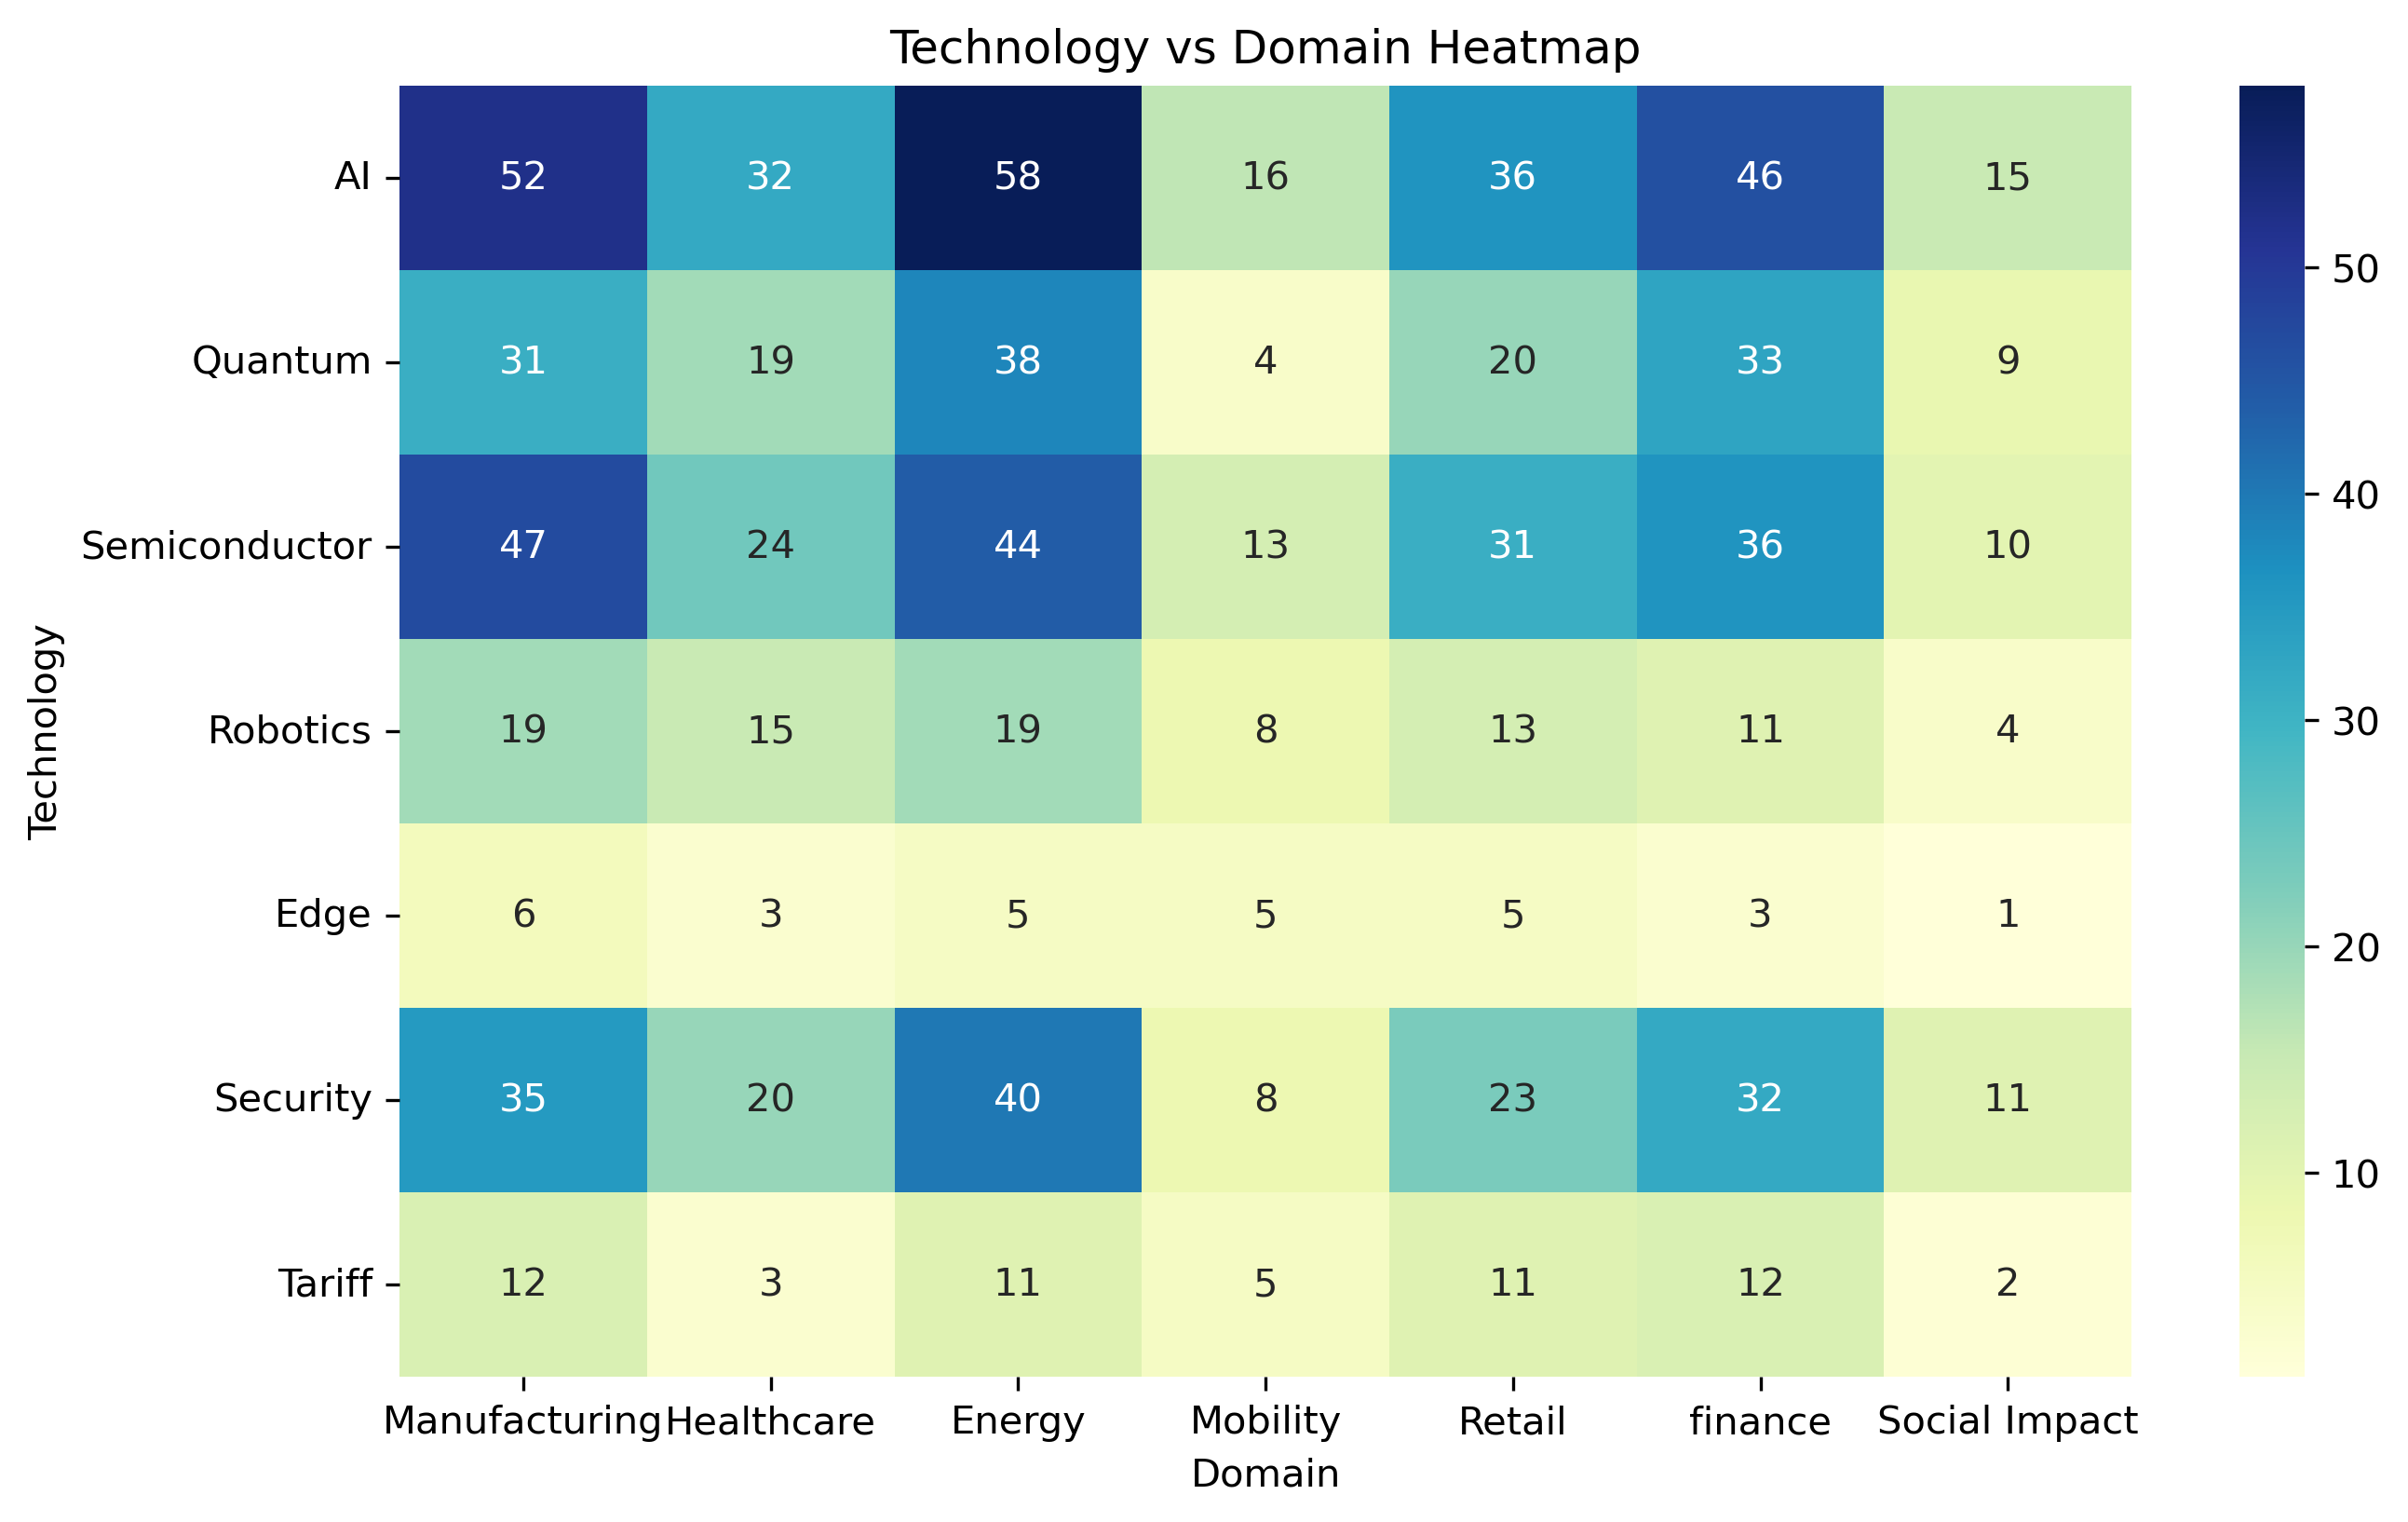

In [14]:
# i want to turn the matrix into heatmap
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6), dpi = 300)
sns.heatmap(matrix_tech_domain, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Technology vs Domain Heatmap")
plt.xlabel("Domain")
plt.ylabel("Technology")
plt.show()

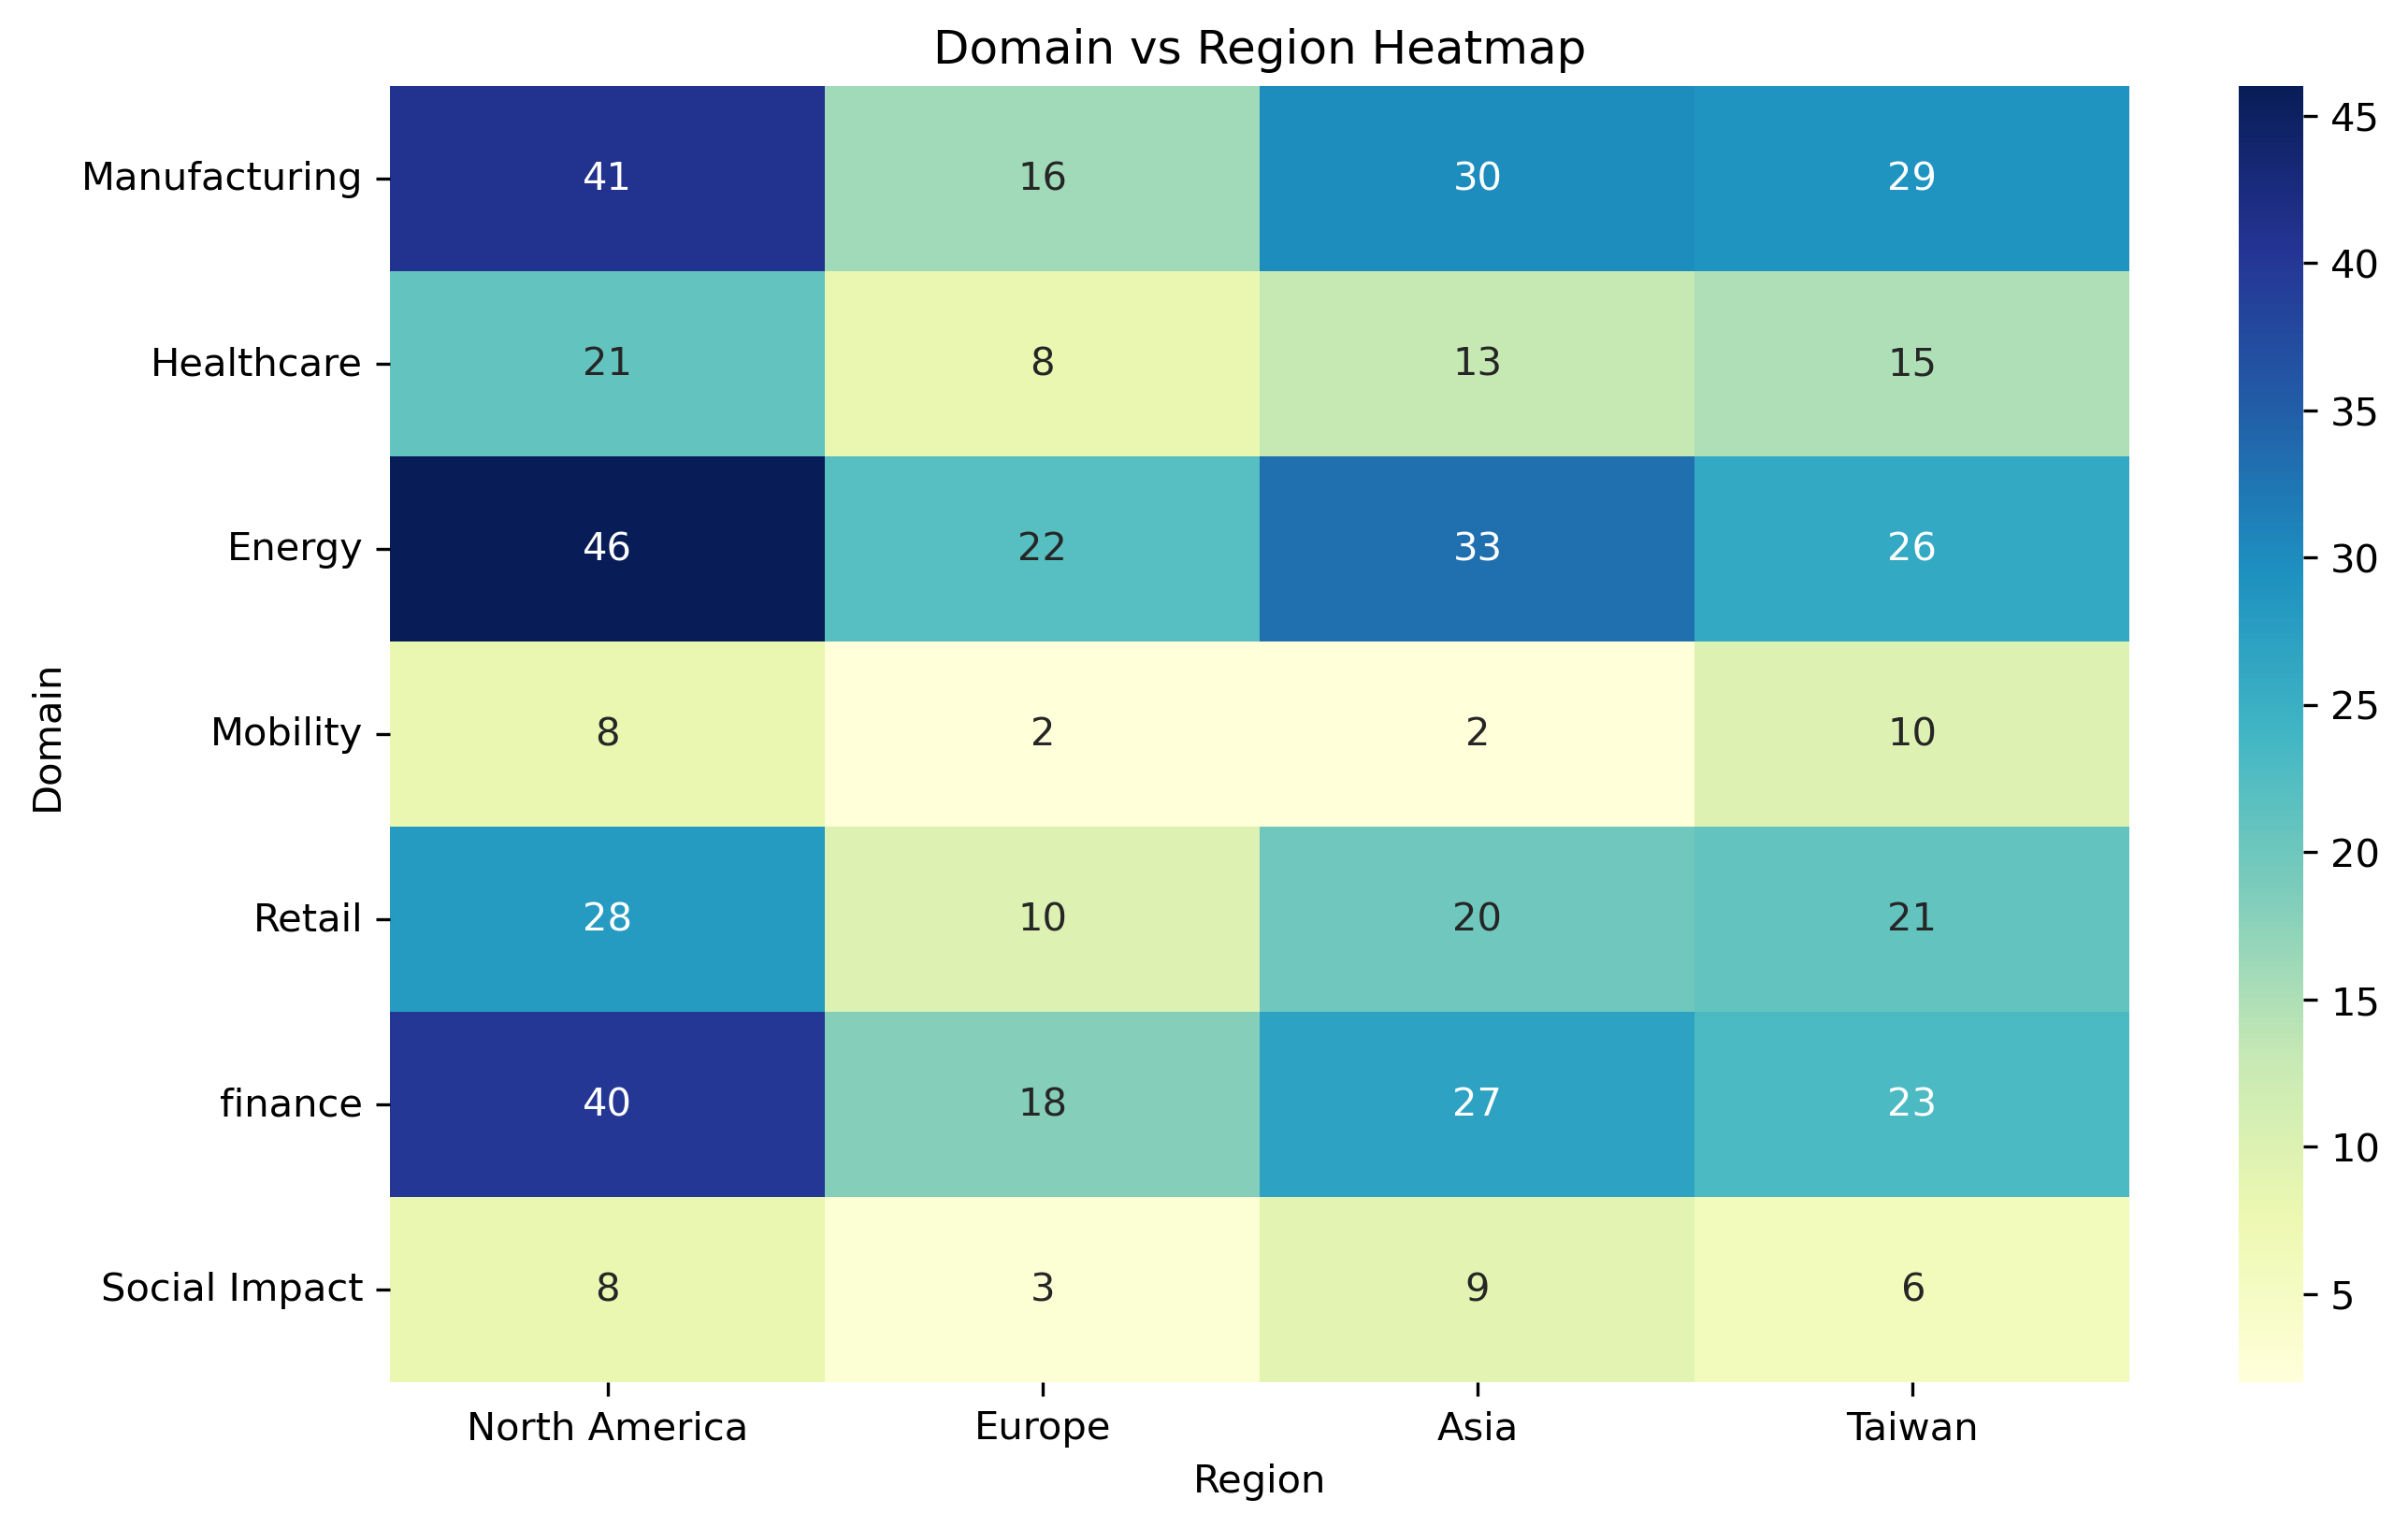

In [139]:
plt.figure(figsize=(10, 6), dpi = 300)
sns.heatmap(matrix_domain_region, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Domain vs Region Heatmap")
plt.xlabel("Region")
plt.ylabel("Domain")
plt.show()

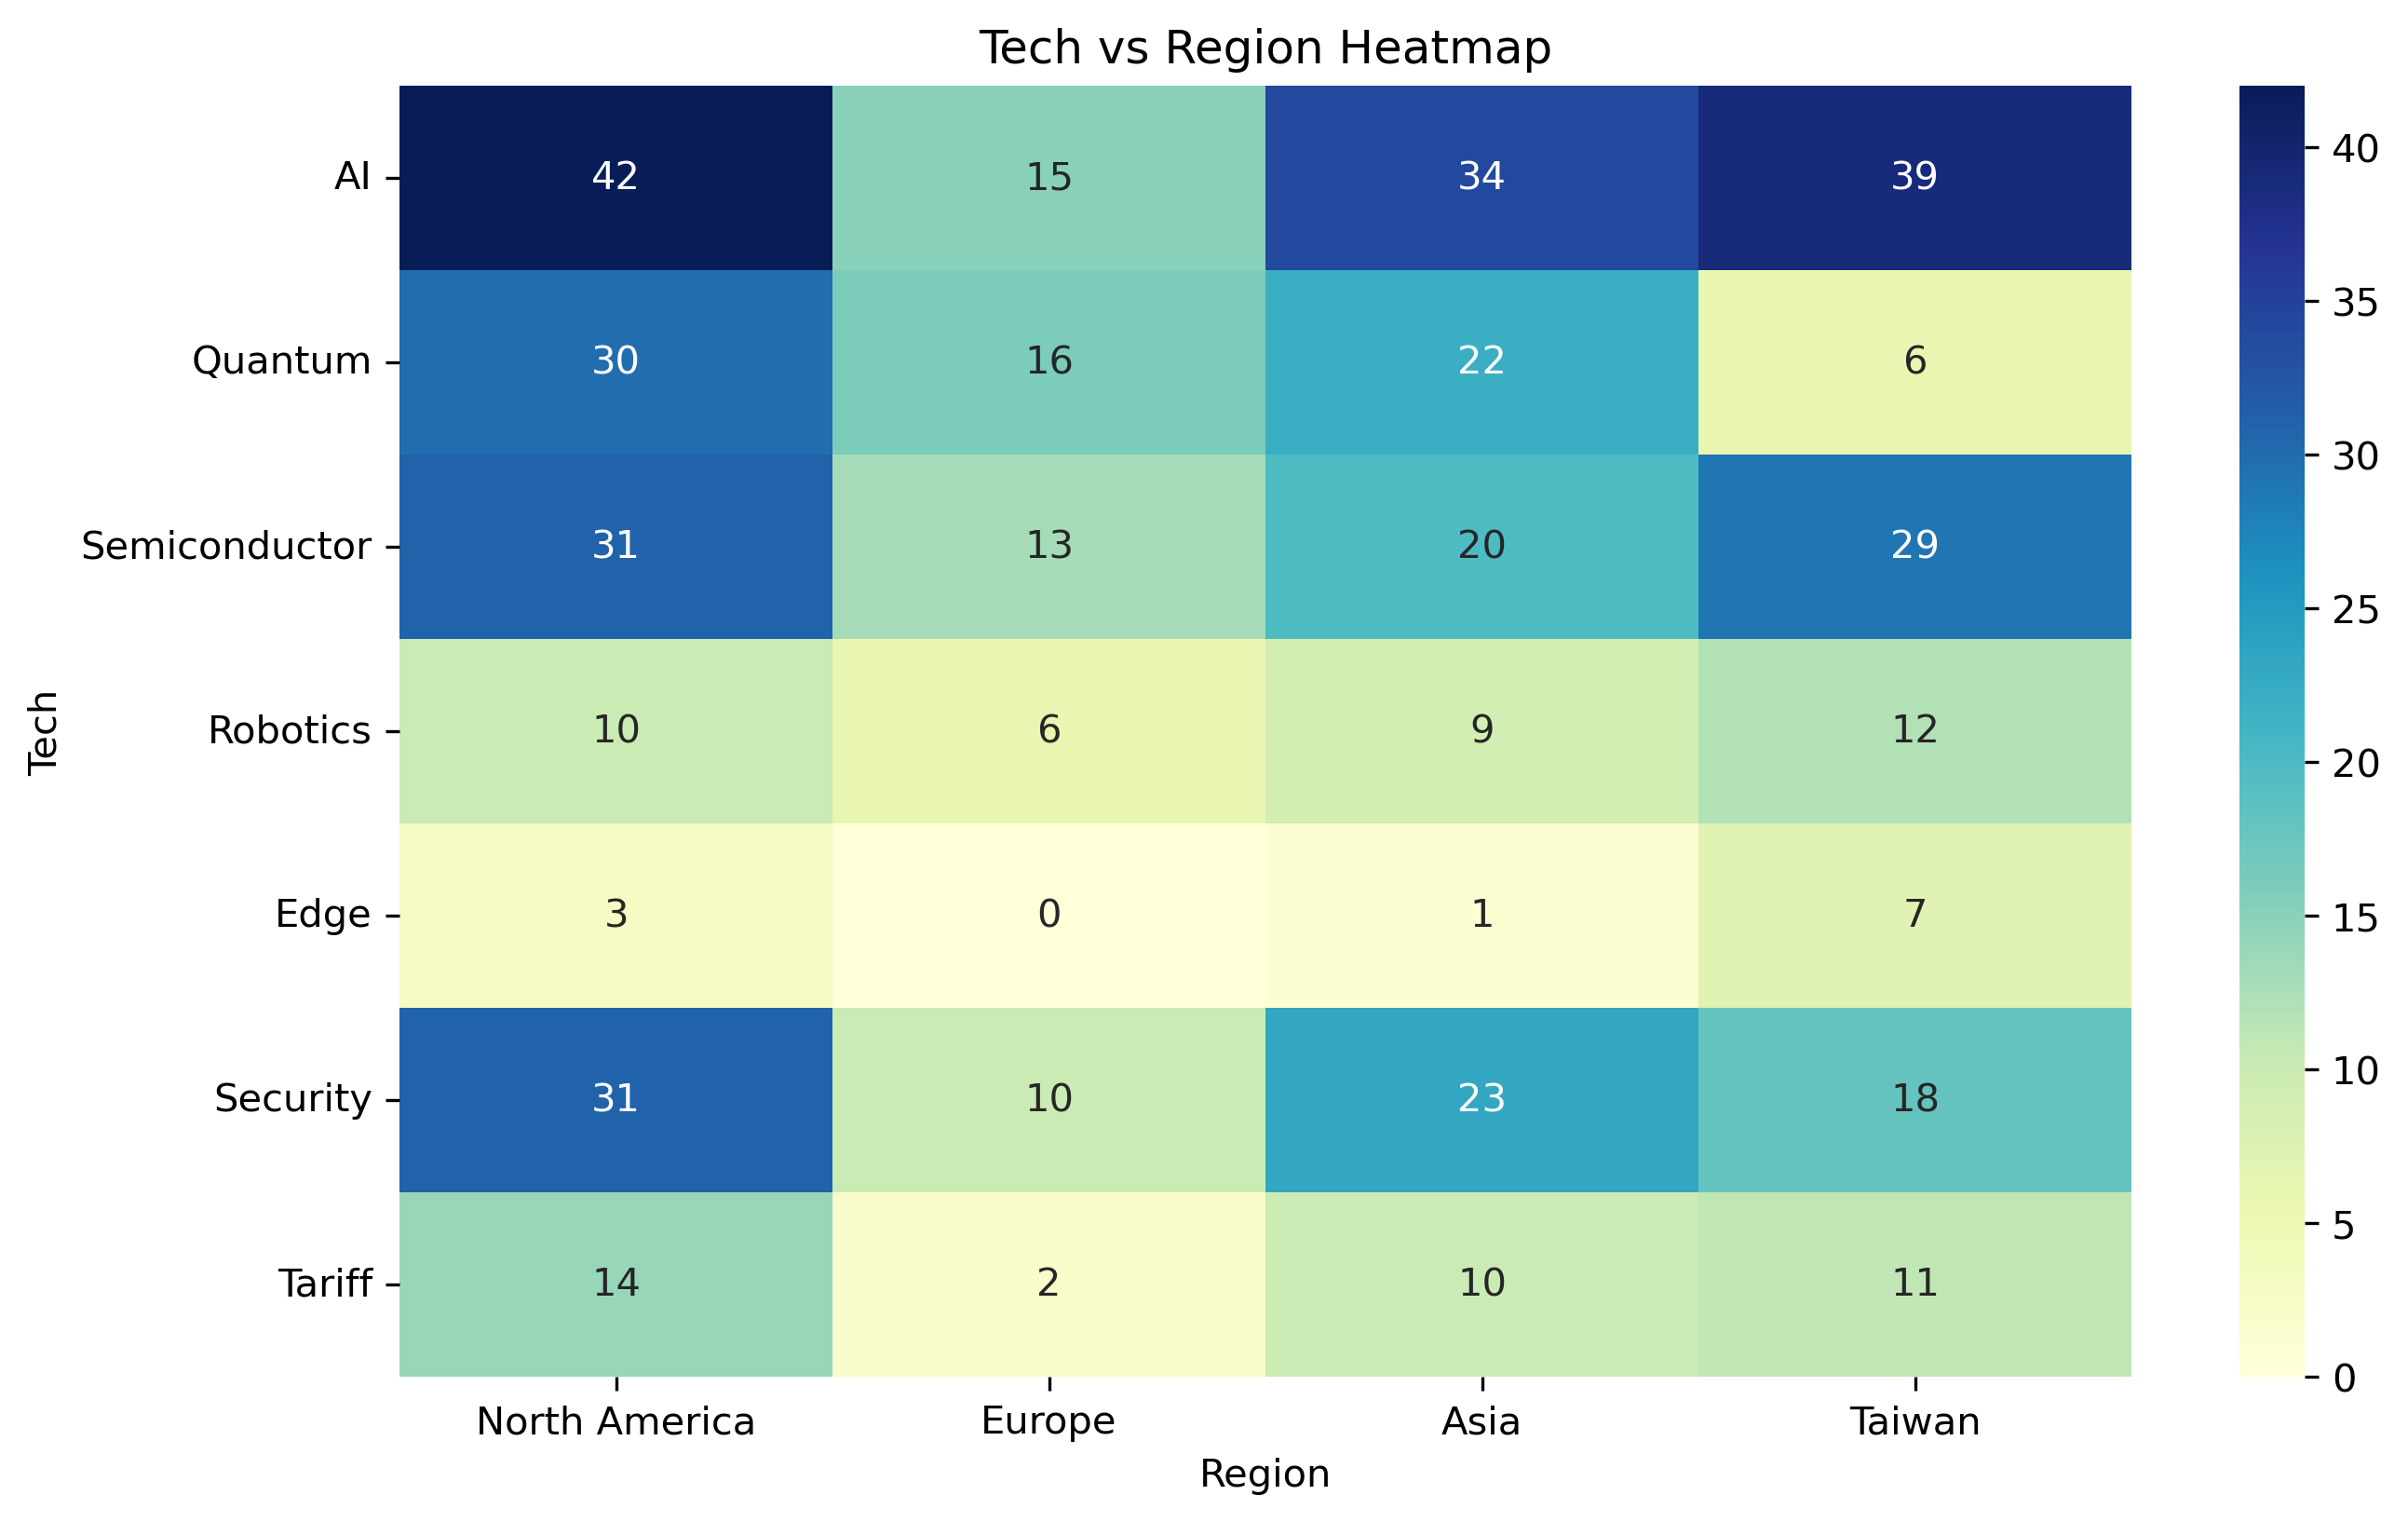

In [18]:
plt.figure(figsize=(10, 6), dpi = 300)
sns.heatmap(matrix_tech_region, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Tech vs Region Heatmap")
plt.xlabel("Region")
plt.ylabel("Tech")
plt.show()

In [116]:
# clean the content by removing extra spaces and /n
cleaned_contents = []
for content in doc_df['content']:
    cleaned = ' '.join(content.split())
    cleaned_contents.append(cleaned)

cleaned_contents

['美國消費電子展（CES）作為全球最具指標性的消費性電子展會，向來被視為年度科技產業的重要風向球。隨著AI技術全面重塑產業樣貌，工研院今（15）日舉辦「透視大展系列：CES 2026重點趨勢研討會」，分享第一手展會觀察。工研院指出，今年 CES大會以「Innovators Show Up」為主題，凸顯AI時代創新的關鍵角色，也呼應當前產業的重要轉折——實體AI加速落地、對話式AI全面滲透，正成為推動產業前行的核心動能。 工研院觀察，今年CES是一場由AI主導的科技轉型，並呈現多項關鍵趨勢，正深刻影響未來數年的生活樣貌與產業格局。一方面，AI算力仍是產業關注重點，NVIDIA、AMD與Intel不再只著眼晶片效能，而是強調從硬體、軟體到平台的整體整合；另一方面，實體AI（Physical AI）持續推進，AI應用逐漸從對話場景延伸至機器人、自動駕駛與各類終端裝置。同時，沉浸式體驗與智慧裝置持續升級，Google旗下Gemini AI 串聯電視、手機、穿戴與車用場景，反映「萬物皆有AI」的發展正逐步落實。 趨勢一：智慧影像、對話式互動與AI家居生態系，打造沉浸式體驗 在消費應用端，影像體驗朝向更沉浸、更智慧發展，RGB Mini-LED 與 Micro RGB 顯示技術普及，AI扮演「視覺管家」的角色，透透過 Vision AI 等技術即時優化畫面、依情境推薦內容。生成式AI（GenAI）也成為電視與家電的核心，對話式介面讓冰箱、烤箱能辨識食材時提供料理建議。今年 CES 也展現了「情境感知」的威力。智慧眼鏡能偵測使用者走進廚房，立即將食譜傳送到冰箱螢幕上；多元感知（Multi-modal sensing）讓裝置能辨識語音、手勢，甚至感測心率，使科技自然融入生活。智慧家庭也由被動操作轉向主動預測，整合能源管理、健康照護與生活協助，逐步形成具備自我學習能力的AI家居生態。 趨勢二：雲端、邊緣及個人算力同步升級，推動AI普及 隨著 AI 從底層架構走向各類應用，全球科技產業正迎來「運算堆疊（Computing Stack）」革命。工研院認為，支撐這股浪潮的核心，在於雲端、邊緣與個人終端算力能否同步、有感升級。資料中心邁向Yotta-scale新紀元，NVIDIA與AMD持續引領超大規模運算架構演進。雲端AI不再只是堆算力，而是走向晶片、系統與軟體整合的一體化模式。同時，個